# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [4]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
import re
import spacy

import torch
import transformers

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from  sklearn.metrics import accuracy_score
from  sklearn.metrics import f1_score
from  sklearn.metrics import classification_report
from  sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier


C:\Users\ramos\anaconda3\envs\p14_tripleten\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(torch.cuda.is_available())

True


In [6]:
import sys
sys.executable

'C:\\Users\\ramos\\anaconda3\\envs\\p14_tripleten\\python.exe'

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [8]:
# usando progress_apply https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [10]:
# df_reviews = pd.read_csv('C:/Users/omarh/Documents/Tripleten/Proyectos/S14/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews = pd.read_csv('C:/Users/ramos/Documents/Tripleten/Proyectos/P14/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})


In [11]:
display(df_reviews.head(4))
df_reviews.info()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [12]:
#Tratando datos nulos
df_reviews.dropna(inplace=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1), floa

In [13]:
df_reviews.head(2)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

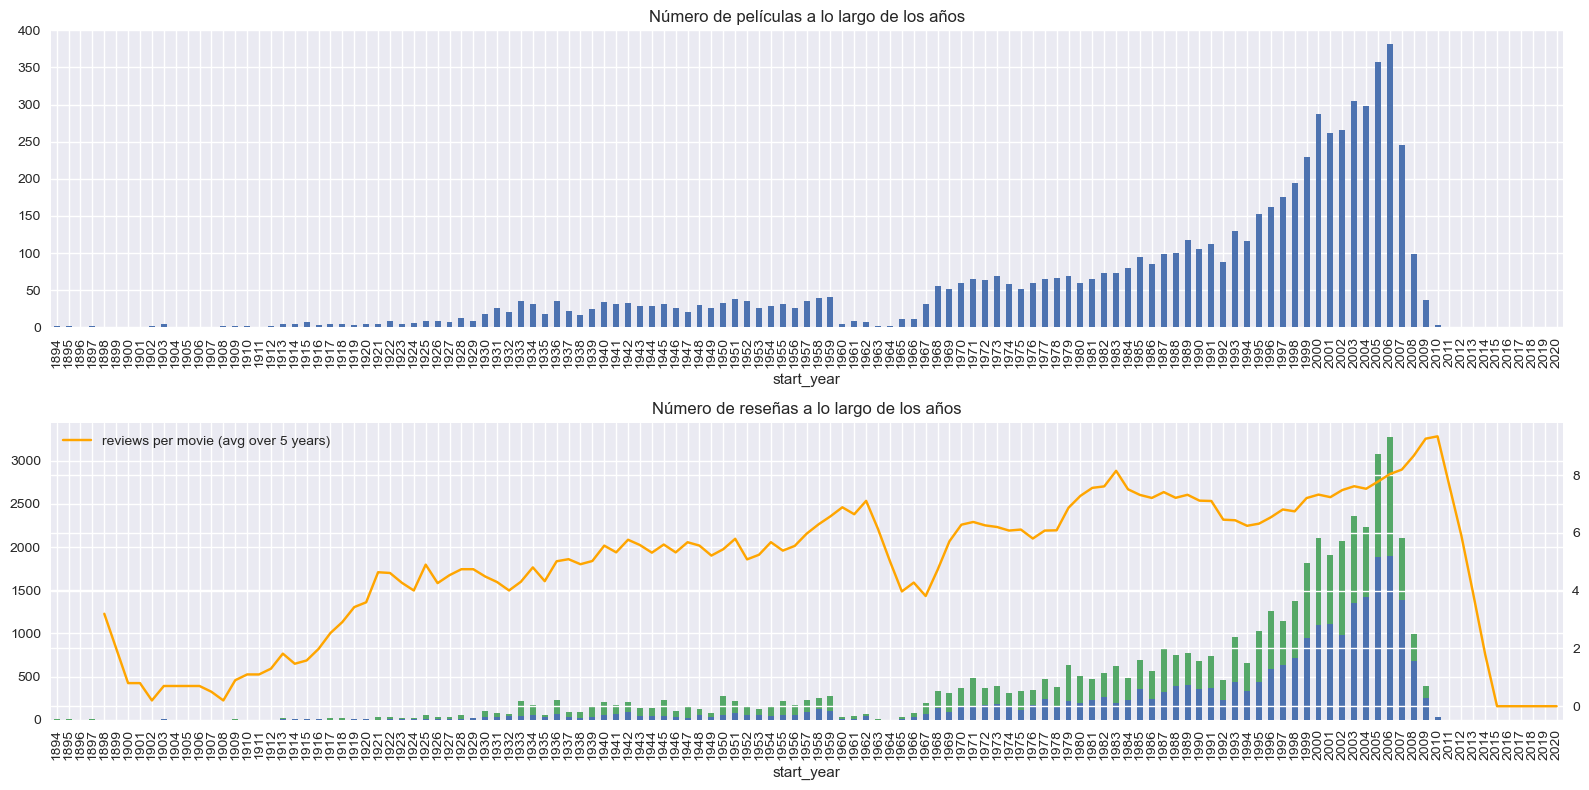

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

**Podemos observar que:**

* A lo largo de los años el número de películas ha ido incrementando hasta su punto máximo en el 2006.
* El número promedio de reseñas a lo largo de los años no ha tenido cambios tan abruptos, sin embargo también tiene una tendencia a la alza


Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

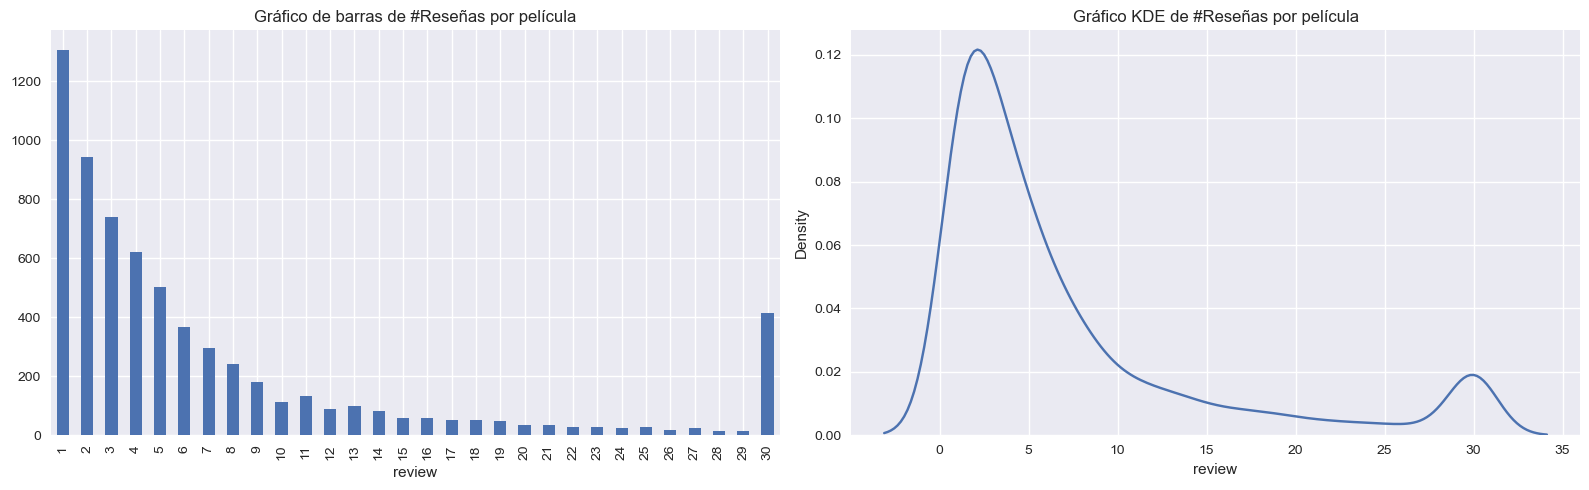

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

**Podemos observar que:**
* Hay muchas películas con pocas reseñas y conforme aumenta la cantidad de reseñas, reduce la frecuencia de películas, un insight interesante es que hay algunas películas con 30 o más reseñas, esto puede ser debido a que son títulos muy exitosos y muchas personas ingresaron a compartir su reseña, sin embargo el escenario más frecuente es que haya muchas películas con solo una reseña.

* El gráfico de densidad KDE nos muestra la distribución de los datos y la representación de densidad que tiene sobre el total, observamos que la mayor parte de las películas tiene entre 1 y 5 reseñas.

In [21]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

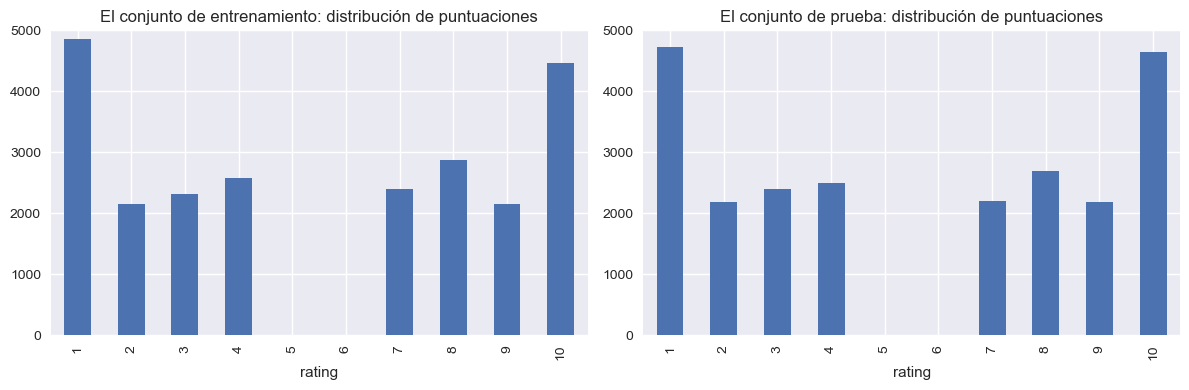

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

In [23]:
rel = df_reviews['pos'].value_counts()/len(df_reviews['pos'])
rel
print(f'Porcentaje de evaluaciones negativas: {round(rel[0],4)}%')
print(f'Porcentaje de evaluaciones positivas: {round(rel[1],4)}%')

Porcentaje de evaluaciones negativas: 0.5011%
Porcentaje de evaluaciones positivas: 0.4989%


**Podemos observar que:**

* La distribución de puntuaciones entre el conjunto de prueba y el conjunto de entrenamiento son similares
* La distribución de clases se encuentra balanceada, con prácticamente un 50% de representación para cada clase

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\ramos\AppData\Local\Temp\ipykernel_17960\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\ramos\AppData\Local\Temp\ipykernel_17960\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\ramos\AppData\Local\Temp\ipykernel_17960\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\ramos\AppData\Local\Temp\ipykernel_17960\1324160450.py:31: UserWarning: 

Support for a

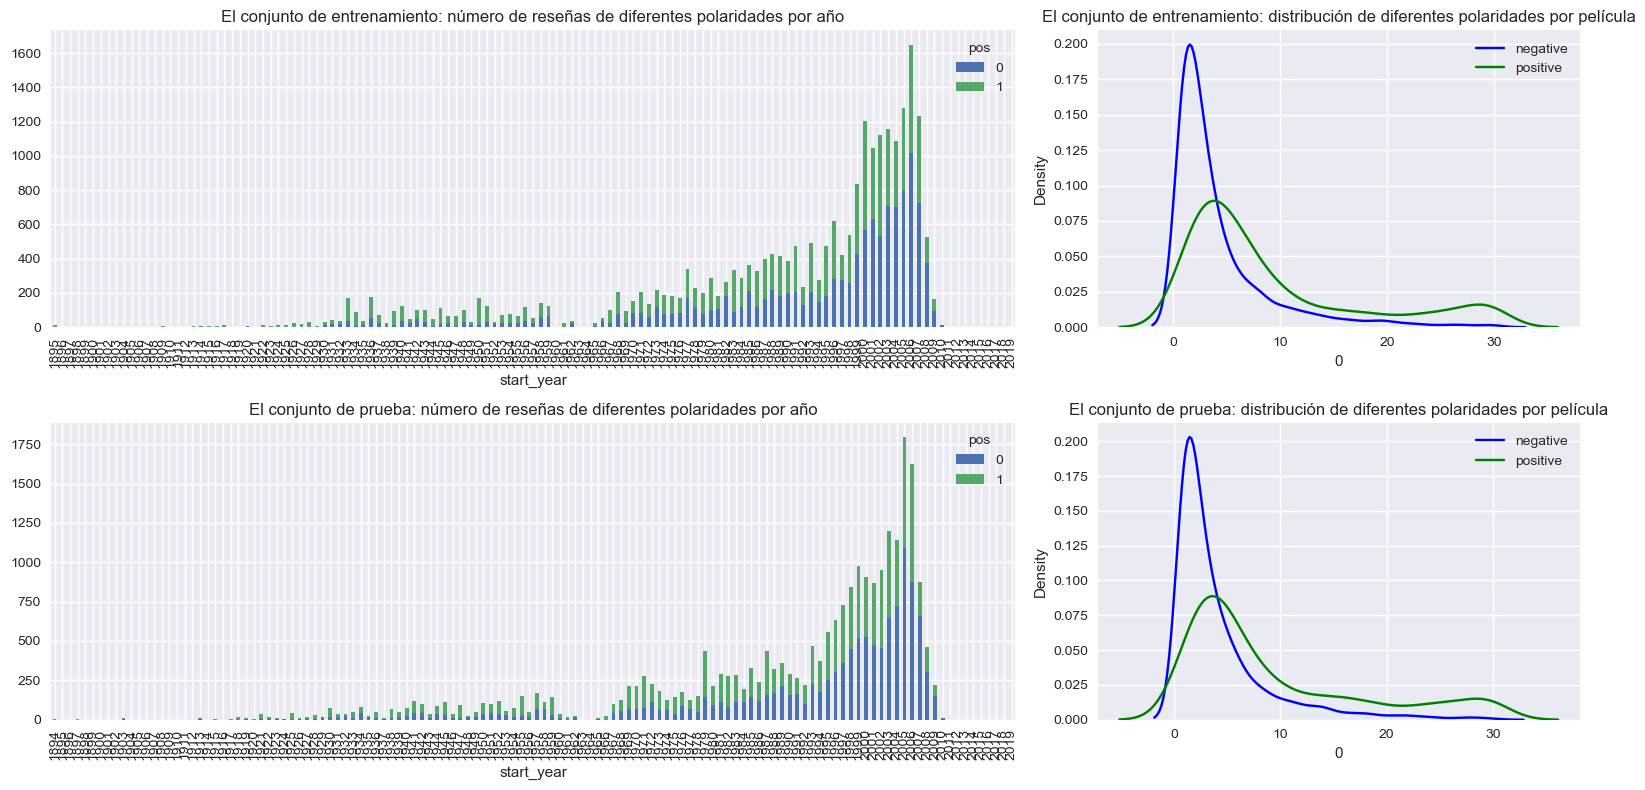

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Cuando comparamos las polaridades de las reseñas de los usuarios en los conjuntos de prueba y entrenamiento, podemos ver diferencias más notorias, observamos que la mayor parte de la distribución se centra en reseñas positivas con una frecuencia prácticamente de relación 2 a 1 sobre las reseñas negativas en ambos conjuntos de datos (entrenamiento y prueba).

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [30]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return 

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [33]:
df_reviews['review'].iloc[1]

'How the hell did they get this made?! Presenting itself as a caper comedy, the misbegotten "$" is essentially two hours of people mumbling sentence fragments. The usually dependable Warren Beatty looks drunk, and the usually hilarious Goldie Hawn acts like she\'s on depressants. As for Gert Frobe, his most famous role - Goldfinger - was infinitely more admirable than his character here. Not even the guy with the champagne bottle of LSD can save this litany of worthlessness. Am I comparing this movie to "Plan 9 from Outer Space"? I wouldn\'t do such a thing even if someone paid me. "P9FOS" was idiotically made but ended up hilarious; this was idiotically made and causes you to feel like your brain just melted out of your ears. Warren Beatty and Goldie Hawn made up for this when they co-starred in "Shampoo", but then they co-starred in the dreadful "Town & Country". Maybe they just shouldn\'t co-star in movies. All in all, I would rather have my skin torn off than have to watch this aga

In [34]:
#Creando patrón regex para eliminar signos de puntuación y dígitos
pattern= r'[^a-zA-Z\s]'
#aplicando lambda
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x : re.sub(pattern,' ',x).strip().lower())
#aplicando regex para hacer todos los espacios en blanco uno solo
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x : re.sub(r'\s+',' ',x))

In [35]:
#verificando resultado
df_reviews['review_norm'].iloc[1]

'how the hell did they get this made presenting itself as a caper comedy the misbegotten is essentially two hours of people mumbling sentence fragments the usually dependable warren beatty looks drunk and the usually hilarious goldie hawn acts like she s on depressants as for gert frobe his most famous role goldfinger was infinitely more admirable than his character here not even the guy with the champagne bottle of lsd can save this litany of worthlessness am i comparing this movie to plan from outer space i wouldn t do such a thing even if someone paid me p fos was idiotically made but ended up hilarious this was idiotically made and causes you to feel like your brain just melted out of your ears warren beatty and goldie hawn made up for this when they co starred in shampoo but then they co starred in the dreadful town country maybe they just shouldn t co star in movies all in all i would rather have my skin torn off than have to watch this again awful maybe they should remake it wit

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [38]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [41]:
from sklearn.dummy import DummyClassifier

Evaluación del DummyClassifier:
           train  test
Exactitud   0.50  0.50
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


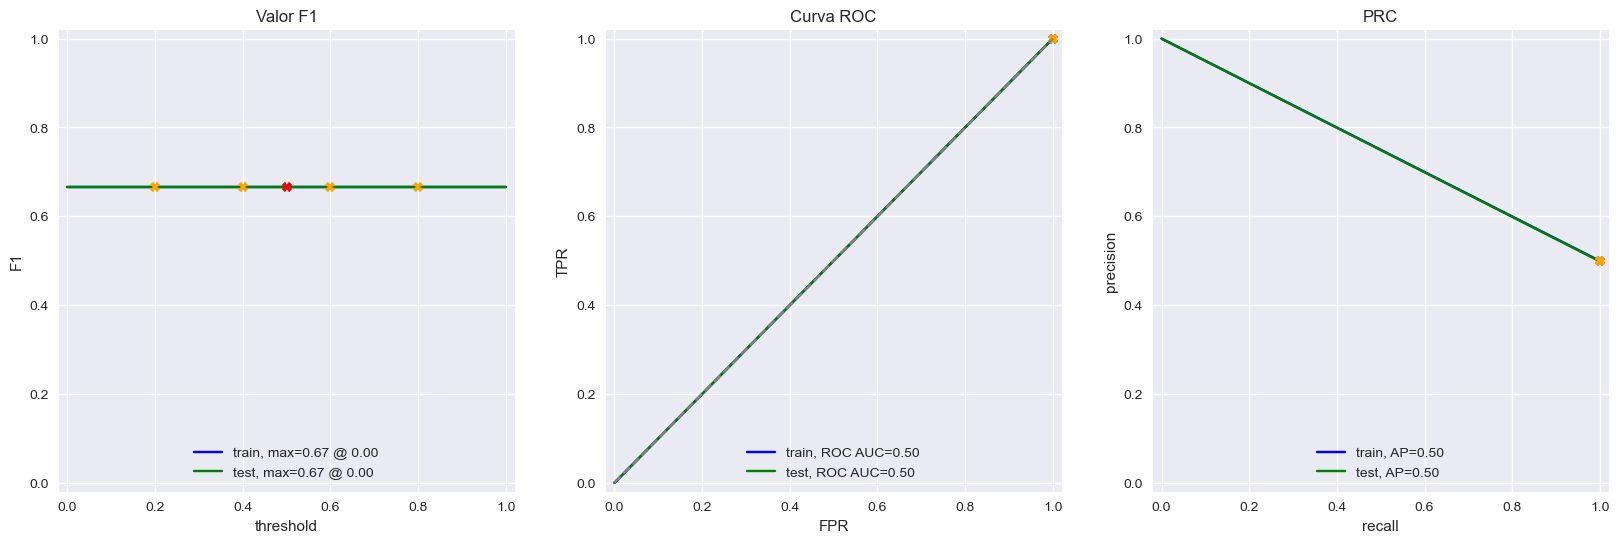

In [42]:
# Crear y entrenar el DummyClassifier
dummy_classifier = DummyClassifier(strategy="constant", constant=1)
dummy_classifier.fit(df_reviews_train[['pos']], train_target)

# Evaluar el DummyClassifier
print("Evaluación del DummyClassifier:")
# evaluate_model(model, train_features, train_target, test_features, test_target)
evaluate_model(dummy_classifier, df_reviews_train[['pos']], train_target, df_reviews_test[['pos']], test_target)

**Podemos observar que:**
* La Exactitud del conjunto de entrenamiento y prueba es de 0.5 lo cual indica que no hay un desequilibrio de clases, sin embargo el modelo no tiene ningún poder predictivo más allá del azar.

* El F1 score es de 0.67 tanto en el conjunto de entrenamiento como el de prueba indicaría que el modelo tiene un equilibrio decente entre precision y recall, sin embargo en el contexto de un modelo Dummy, no nos aporta nada esta métrica.

* El valor APS de 0.5 para ambos conjuntos de datos es esperado en un modelo sin capacidades predictivas, simplemente basado en el azar.

* El valor AUC-ROC nos termina de confirmar que el desempeño no es mejor que el azar, debido a que no supera el valor de 0.5, tampoco es peor al azar al no disminuir de 0.5.


### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [46]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ramos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ramos\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [47]:
stop_words = list(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Por defecto, considera como sustantivo


def preprocess_text_nltk(reviews):
    
    #creando tokens
    tokens = word_tokenize(reviews)
    # Etiquetas de POS para los tokens
    pos_tags = nltk.pos_tag(tokens)
    #creando lemas
    lemmas = [lemmatizer.lemmatize(token,get_wordnet_pos(pos)) for token,pos in pos_tags]

    
    
    return ' '.join(lemmas)





In [48]:
#Probando la lematizacion en una frase dummy 
print(preprocess_text_nltk('The dogs are running quickly.'))


The dog be run quickly .


In [49]:
#Procesando reviews con nltk
df_reviews_train['review_nltk'] = df_reviews_train['review_norm'].progress_apply(preprocess_text_nltk)
df_reviews_test['review_nltk'] = df_reviews_test['review_norm'].progress_apply(preprocess_text_nltk)


100%|████████████████████████████████████████████████████████████████████████████| 23533/23533 [03:56<00:00, 99.33it/s]


In [50]:
#Verificando estructura de los reviews con nltk vs estado inicial
df_reviews_train['review_nltk'].iloc[1]

'how the hell do they get this make present itself a a caper comedy the misbegotten be essentially two hour of people mumble sentence fragment the usually dependable warren beatty look drunk and the usually hilarious goldie hawn act like she s on depressant a for gert frobe his most famous role goldfinger be infinitely more admirable than his character here not even the guy with the champagne bottle of lsd can save this litany of worthlessness be i compare this movie to plan from out space i wouldn t do such a thing even if someone pay me p fo be idiotically make but end up hilarious this be idiotically make and cause you to feel like your brain just melt out of your ear warren beatty and goldie hawn make up for this when they co star in shampoo but then they co star in the dreadful town country maybe they just shouldn t co star in movie all in all i would rather have my skin tear off than have to watch this again awful maybe they should remake it with jackie chan then i would pay to s

In [51]:
df_reviews_train['review_norm'].iloc[1]

'how the hell did they get this made presenting itself as a caper comedy the misbegotten is essentially two hours of people mumbling sentence fragments the usually dependable warren beatty looks drunk and the usually hilarious goldie hawn acts like she s on depressants as for gert frobe his most famous role goldfinger was infinitely more admirable than his character here not even the guy with the champagne bottle of lsd can save this litany of worthlessness am i comparing this movie to plan from outer space i wouldn t do such a thing even if someone paid me p fos was idiotically made but ended up hilarious this was idiotically made and causes you to feel like your brain just melted out of your ears warren beatty and goldie hawn made up for this when they co starred in shampoo but then they co starred in the dreadful town country maybe they just shouldn t co star in movies all in all i would rather have my skin torn off than have to watch this again awful maybe they should remake it wit

In [52]:
# count_tf_idf = TfidfVectorizer(stop_words= stop_words)
tfidf_vectorizer = TfidfVectorizer(stop_words= stop_words, max_features=1000)

train_features_tf_idf_nltk = tfidf_vectorizer.fit_transform(df_reviews_train['review_nltk'])
test_features_tf_idf_nltk = tfidf_vectorizer.transform(df_reviews_test['review_nltk'])

display(train_features_tf_idf_nltk.shape)
display(test_features_tf_idf_nltk.shape)

(23796, 1000)

(23533, 1000)

In [53]:
model_1 = LogisticRegression()
model_1.fit(train_features_tf_idf_nltk, train_target)
# lr_pred = model_lr.predict(test_features_tf_idf_nltk)

LogisticRegression()

Evaluación del Modelo 1 - NLTK, TF-IDF y LR:
           train  test
Exactitud   0.87  0.86
F1          0.87  0.86
APS         0.94  0.93
ROC AUC     0.95  0.94


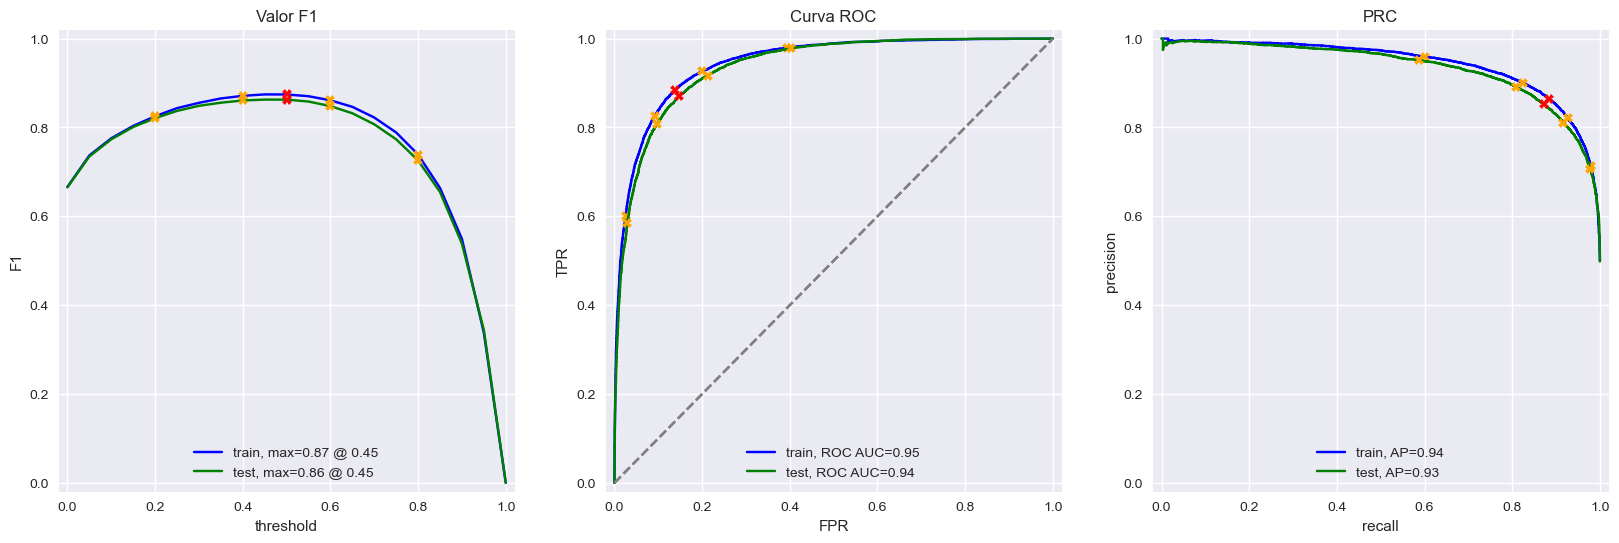

In [54]:
# Evaluar el Modelo 1 - NLTK, TF-IDF y LR
print("Evaluación del Modelo 1 - NLTK, TF-IDF y LR:")
evaluate_model(model_1, train_features_tf_idf_nltk, train_target, test_features_tf_idf_nltk, test_target)

**Podemos observar que:**
* La Exactitud del conjunto de entrenamiento es de  0.87 y en el conjunto de prueba es de 0.86 lo cual indica que el modelo no está sobreajustado.

* El F1 score es de 0.88 para el conjunto de entrenamiento y e 0.86 en el de prueba, esto indica que el modelo tiene un desempeño muy bueno entre la precisión y la exhaustividad(recall) esto se traduce a la capacidad de predicción del modelo y la capacidad de acertar en la mayoría de los verdaderos positivos.

* El valor APS de 0.94 y 0.93 para ambos conjuntos de datos reafirma al F1 score, mostrándonos que el modelo tiene una precisión muy alta, que se traduce a que si el modelo predice un valor, la probabilidad de que haya acertado es muy alta

* El valor AUC-ROC de 0.95 y 0.94 respectivamente nos muestra una medida "general" de que nuestro modelo tiene un desempeño excelente a la hora de distinguir entre clases positivas y negativas

### Modelo 3 - spaCy, TF-IDF y LR

In [57]:
import sys
sys.executable

'C:\\Users\\ramos\\anaconda3\\envs\\p14_tripleten\\python.exe'

In [58]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [59]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    
    return ' '.join(tokens)

In [60]:
#Procesando reviews con spacy 
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

100%|████████████████████████████████████████████████████████████████████████████| 23533/23533 [05:28<00:00, 71.59it/s]


In [61]:
train_features_tf_idf_spacy= tfidf_vectorizer.fit_transform(df_reviews_train['review_spacy'])
test_features_tf_idf_spacy= tfidf_vectorizer.transform(df_reviews_test['review_spacy'])

Evaluación del Modelo 3 - spaCy, TF-IDF y LR:
           train  test
Exactitud   0.87  0.85
F1          0.87  0.86
APS         0.94  0.93
ROC AUC     0.94  0.93


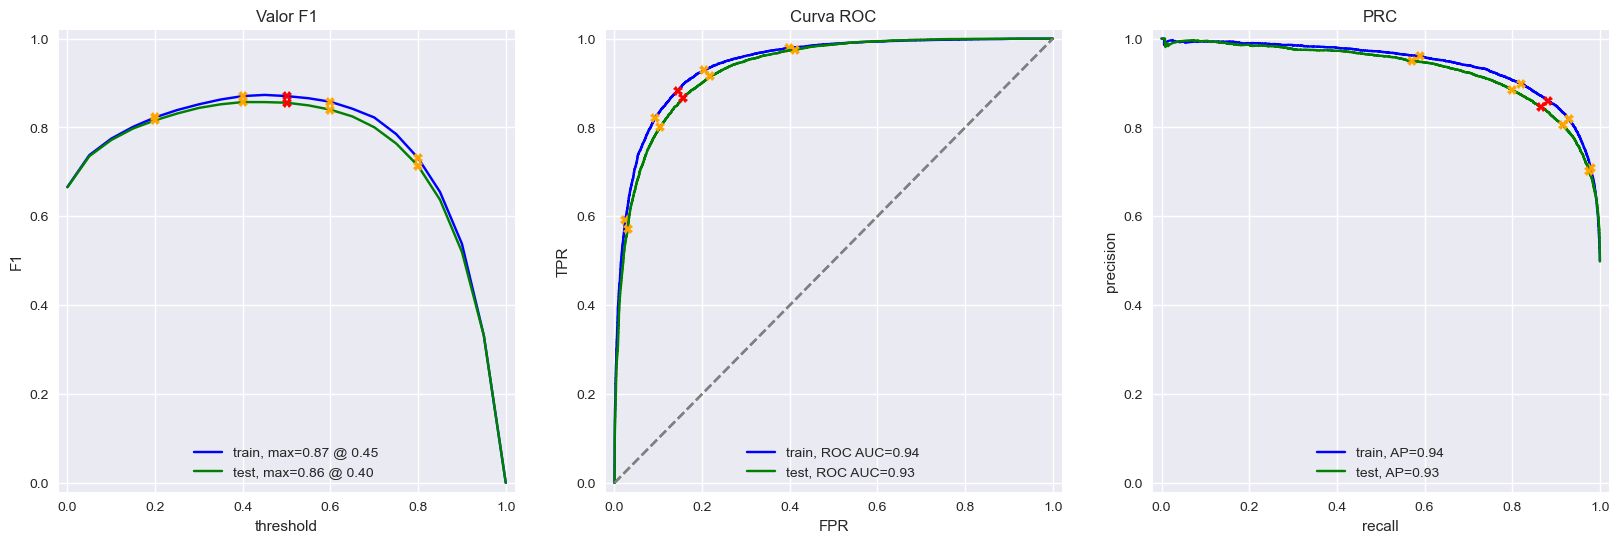

In [62]:
model_2= LogisticRegression()
model_2.fit(train_features_tf_idf_spacy,train_target)
# Evaluar el Modelo 3 - spaCy, TF-IDF y LR
print("Evaluación del Modelo 3 - spaCy, TF-IDF y LR:")
evaluate_model(model_2, train_features_tf_idf_spacy, train_target, test_features_tf_idf_spacy, test_target)


**Podemos observar que:**

* La Exactitud del conjunto de entrenamiento es de 0.87 y en el conjunto de prueba es de 0.85 lo cual indica que el modelo no está sobreajustado.

* El F1 score es de 0.87  para el conjunto de entrenamiento y e 0.86 en el de prueba, esto indica que el modelo tiene un desempeño muy bueno entre la precisión y la exhaustividad(recall) esto se traduce a la capacidad de predicción del modelo y la capacidad de acertar en la mayoría de los verdaderos positivos.

* El valor APS de 0.94 y 0.93 para ambos conjuntos de datos reafirma al F1 score, mostrándonos que el modelo tiene una precisión muy alta, que se traduce a que si el modelo predice un valor, la probabilidad de que haya acertado es muy alta

* El valor AUC-ROC de 0.94 y 0.93 respectivamente nos muestra una medida "general" de que nuestro modelo tiene un desempeño excelente a la hora de distinguir entre clases positivas y negativas

**En general el modelo utilizando Spacy tuvo un desempeño "ligeramente" menor al modelo NLTK, sin embargo es tan pequeño que podría pasar como despreciable, ambos modelos tienen un muy buen desempeño**

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209964
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Evaluación del Modelo 4 - spaCy, TF-IDF y LGBMClassifier:
           train  test
Exactitud   0.90  0.84
F1          0.90  0.84
APS         0.96  0.92
ROC AUC     0.97  0.92


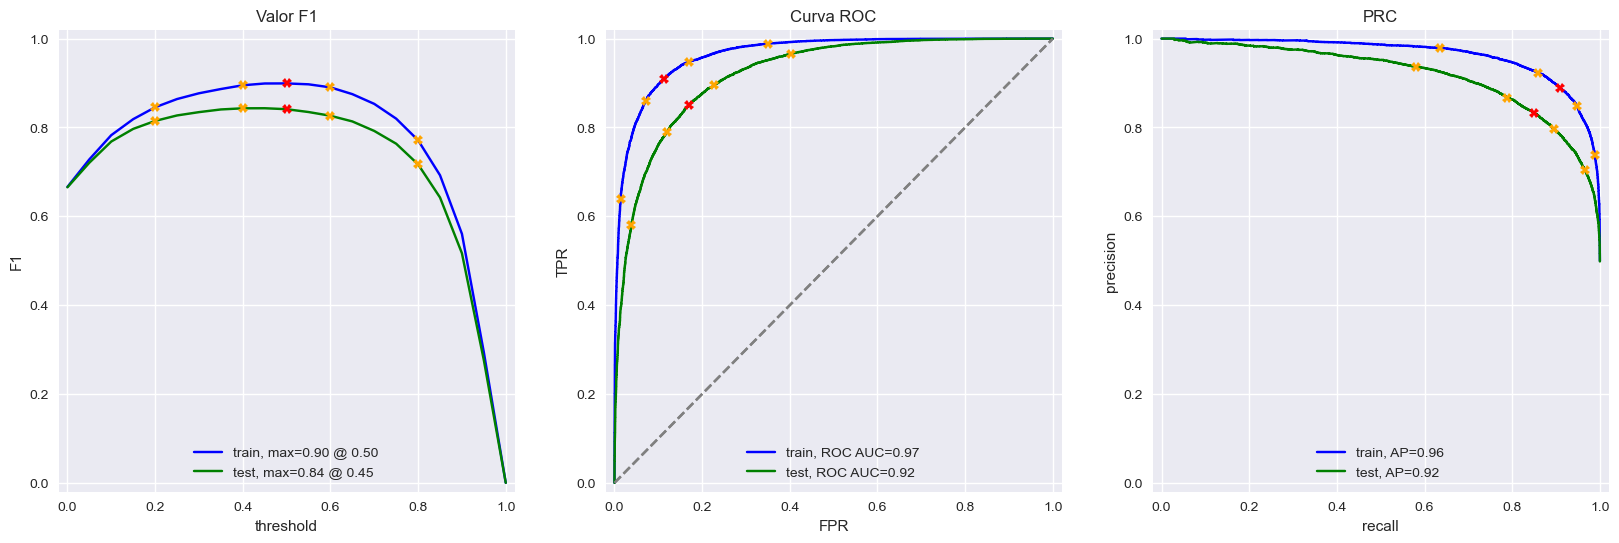

In [65]:
model_3 = LGBMClassifier(class_weight='balanced',random_state=12345)
model_3.fit(train_features_tf_idf_spacy,train_target)

# Evaluar el Modelo 4 - spaCy, TF-IDF y LGBMClassifier
print("Evaluación del Modelo 4 - spaCy, TF-IDF y LGBMClassifier:")
evaluate_model(model_3, train_features_tf_idf_spacy, train_target, test_features_tf_idf_spacy, test_target)

**Podemos observar que:**

* La Exactitud del conjunto de entrenamiento es de 0.90 y en el conjunto de prueba es de 0.84 lo cual indica que el modelo no está sobreajustado.

* El F1 score es de 0.90  para el conjunto de entrenamiento y e 0.84 en el de prueba, esto indica que el modelo tiene un desempeño muy bueno entre la precisión y la exhaustividad(recall) esto se traduce a la capacidad de predicción del modelo y la capacidad de acertar en la mayoría de los verdaderos positivos.

* El valor APS de 0.96 y 0.92 para ambos conjuntos de datos reafirma al F1 score, mostrándonos que el modelo tiene una precisión muy alta, que se traduce a que si el modelo predice un valor, la probabilidad de que haya acertado es muy alta

* El valor AUC-ROC de 0.97 y 0.92 respectivamente nos muestra una medida "general" de que nuestro modelo tiene un desempeño excelente a la hora de distinguir entre clases positivas y negativas

**En general el modelo LGBM Regressor mostró un desempeño muy bueno en la tarea de clasificación de reseñas, vemos una ligera disminución generalizada en las métricas del conjunto de prueba en relación a los otros dos modelos (NLTK-Spacy), no considero que estas diferencias determinen un sobreajuste del modelo, sin embargo se podría buscar implementar estrategias de ajuste de hiperparámetros para verificar si el modelo presenta un mejor desempeño.**

### Modelo 4.1 - spaCy, TF-IDF con ensamblaje de modelos voting classifier (LGBMClassifier + Random Forest Classifier + LogisticRegression)
**Decidimos utilizar esta estrategia para buscar una mejora en el F1 score y aumentarlo al umbral deseado (0.85).**

Con esta estrategia, mediante el Voting Classifier combinamos las bondades de los tres modelos:
* LGBM es muy bueno para capturar relaciones complejas y no lineales
* Random Forest Classifier es robusto a sobreajuste y bueno para manejar datos con muchas características
* Logistic Regression es simple y efectivo para relaciones lineales y proporciona probabilidades de clase interpretables

**Utilizamos las predicciones finales de los tres modelos y mediante el promedio de las probabilidades de clase (voting='soft') logramos aumentar el F1 score (así como también el desempeño en el resto de las métricas)**


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209964
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
Evaluación del Modelo 4.1 - spaCy, TF-IDF con ensamblaje de modelos voting classifier:
           train  test
Exactitud   0.95  0.85
F1          0.95  0.85
APS         0.99  0.93
ROC AUC     0.99  0.93


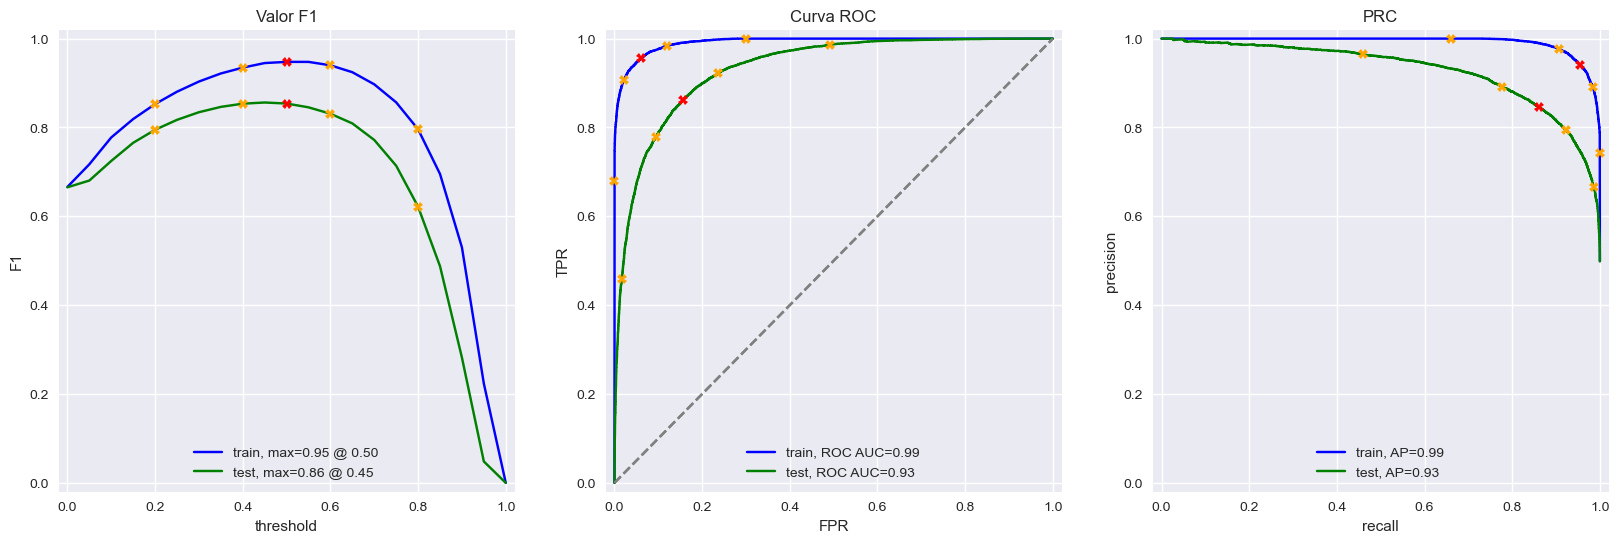

In [68]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

model1 = LGBMClassifier(random_state=12345)
model2 = RandomForestClassifier(random_state=12345)
model3 = LogisticRegression(random_state=12345)

ensemble_model = VotingClassifier(estimators=[
    ('lgbm', model1), 
    ('rf', model2), 
    ('lr', model3)
], voting='soft')

ensemble_model.fit(train_features_tf_idf_spacy, train_target)
# Evaluar el Modelo 4.1 - spaCy, TF-IDF con ensamblaje de modelos voting classifier
print("Evaluación del Modelo 4.1 - spaCy, TF-IDF con ensamblaje de modelos voting classifier:")
evaluate_model(ensemble_model, train_features_tf_idf_spacy, train_target, test_features_tf_idf_spacy, test_target)


**Podemos observar que:**

* La Exactitud del conjunto de entrenamiento es de 0.95 y en el conjunto de prueba es de 0.85 lo cual indica que el modelo podría acercarse a un riesgo de sobreajuste.

* El F1 score es de 0.95 para el conjunto de entrenamiento y e 0.85 en el de prueba, esto indica que el modelo tiene un desempeño muy bueno entre la precisión y la exhaustividad(recall) esto se traduce a la capacidad de predicción del modelo y la capacidad de acertar en la mayoría de los verdaderos positivos.

* El valor APS de 0.99 y 0.93 para ambos conjuntos de datos reafirma al F1 score, mostrándonos que el modelo tiene una precisión muy alta, que se traduce a que si el modelo predice un valor, la probabilidad de que haya acertado es muy alta

* El valor AUC-ROC de 0.99 y 0.93 respectivamente nos muestra una medida "general" de que nuestro modelo tiene un desempeño excelente a la hora de distinguir entre clases positivas y negativas.


**En general el desempeño del modelo con el conjunto de prueba mejoró, sin embargo la diferencia de las métricas entre el conjunto de prueba y el conjunto de entrenamiento incrementaron, por lo tanto podríamos estarnos enfrentando a un sobreajuste del modelo, tomando en cuenta que una estrategia GridSearchCV tiene un costo computacional "alto" (con tiempos computacionales mayores a 10 minutos) en relación al modelo Voting Classifier, podríamos asumir el riesgo de las diferencias en las métricas entre los conjuntos de entrenamiento y prueba, a fin de mejorar el F1 Score tal como es el objetivo de este proyecto.**
ricas)**

###  Modelo 9 - BERT

In [71]:
display(df_reviews_train.shape)
display(df_reviews_test.shape)
display(train_target.shape)
display(test_target.shape)

(23796, 20)

(23533, 20)

(23796,)

(23533,)

In [72]:
# Obtener el 10% de los datos para entrenamiento
df_reviews_train_sample = df_reviews_train.sample(frac=0.1, random_state=42)
target_train_sample = train_target.loc[df_reviews_train_sample.index]

# Obtener el 10% de los datos para prueba
df_reviews_test_sample = df_reviews_test.sample(frac=0.1, random_state=42)
target_test_sample = test_target.loc[df_reviews_test_sample.index]
df_reviews_test_sample.shape

(2353, 20)

In [73]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased', force_download=True)
model = transformers.BertModel.from_pretrained('bert-base-uncased', force_download=True)

C:\Users\ramos\anaconda3\envs\p14_tripleten\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\ramos\anaconda3\envs\p14_tripleten\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ramos\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Pyt

In [74]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
    for input_text in texts:
        ids = tokenizer.encode(input_text,add_special_tokens=True,truncation=True, max_length=max_length)
        padded= np.array(ids + [0]*(max_length- len(ids)))
        attention_mask = np.where(padded!=0,1,0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
       
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
          
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        #Unión de vectores de ids(de tokens) a un tensor
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # Unión de vectores de máscaras de atención a un tensor
        # attention_mask_batch= torch.LongTensor(attention_mask_list[batch_size * i : batch_size[i+1]])
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i : batch_size * (i + 1)]).to(device)


        # Creando un batch de embeddings
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        #Convirtiendo elementos de tensor a numpy.array 
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [75]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
train_features_9 = BERT_text_to_embeddings(df_reviews_train_sample['review_norm'], force_device='cuda')
test_features_9 = BERT_text_to_embeddings(df_reviews_test_sample['review_norm'], force_device='cuda')

Uso del dispositivo cuda.


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]C:\Users\ramos\AppData\Local\Temp\ipykernel_17960\717273505.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:14<00:00,  3.08s/it]


Uso del dispositivo cuda.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:15<00:00,  3.15s/it]


In [76]:
# Guardando los insertados (características) en un archivo comprimido
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']
print("Dimensiones de características de entrenamiento:", train_features_9.shape)
print("Dimensiones de características de prueba:", test_features_9.shape)

Dimensiones de características de entrenamiento: (2380, 768)
Dimensiones de características de prueba: (2353, 768)


In [77]:
model_lr_bert = LogisticRegression()
model_lr_bert.fit(train_features_9,target_train_sample)
bert_predictions = model_lr_bert.predict(test_features_9)

C:\Users\ramos\anaconda3\envs\p14_tripleten\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluación del Modelo 9 - BERT:
           train  test
Exactitud   0.93  0.84
F1          0.93  0.84
APS         0.98  0.92
ROC AUC     0.98  0.92


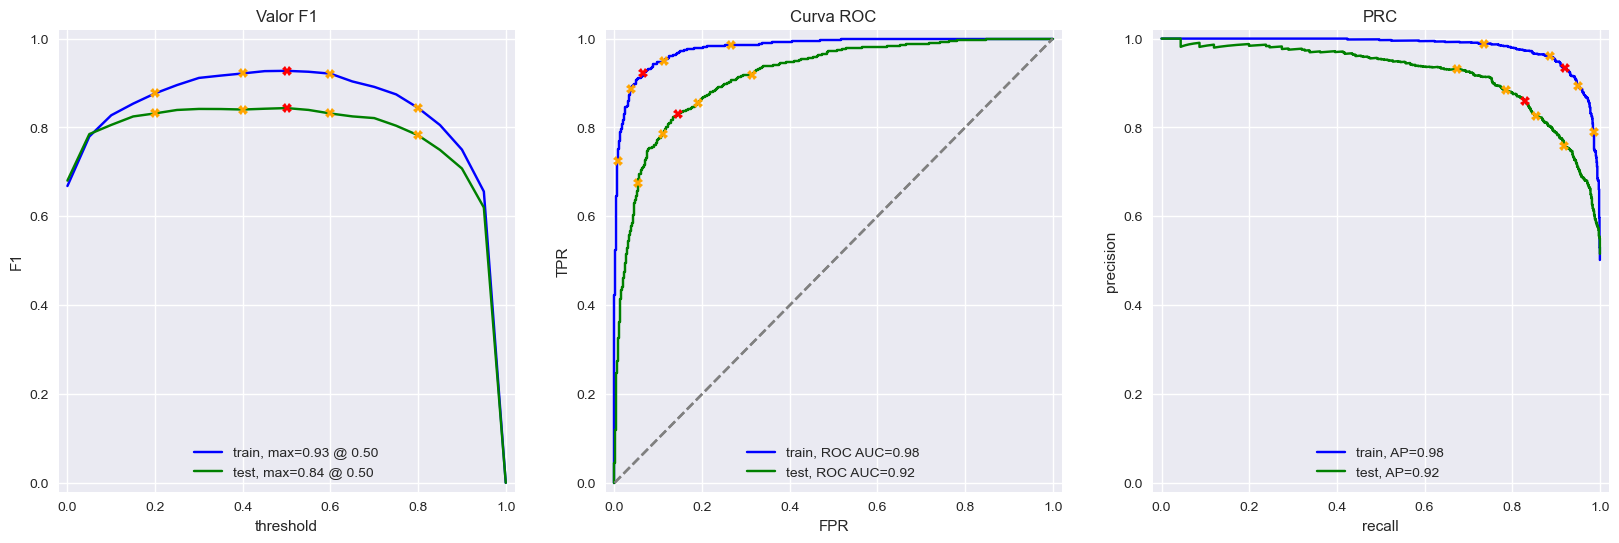

In [78]:
# Evaluar el Modelo 9 - BERT
print("Evaluación del Modelo 9 - BERT:")
evaluate_model(model_lr_bert,train_features_9,target_train_sample, test_features_9,target_test_sample)

**Podemos observar que:**

* La Exactitud del conjunto de entrenamiento es de 0.93 y en el conjunto de prueba es de 0.84 lo cual indica que el modelo podría acercarse a un riesgo de sobreajuste.

* El F1 score es de 0.93 para el conjunto de entrenamiento y e 0.84 en el de prueba, esto indica que el modelo tiene un desempeño muy bueno entre la precisión y la exhaustividad(recall) esto se traduce a la capacidad de predicción del modelo y la capacidad de acertar en la mayoría de los verdaderos positivos.

* El valor APS de 0.98 y 0.92 para ambos conjuntos de datos reafirma al F1 score, mostrándonos que el modelo tiene una precisión muy alta, que se traduce a que si el modelo predice un valor, la probabilidad de que haya acertado es muy alta

* El valor AUC-ROC de 0.98 y 0.92 respectivamente nos muestra una medida "general" de que nuestro modelo tiene un desempeño muy bueno a la hora de distinguir entre clases positivas y negativas.


**En general el desempeño del modelo BERT fue bueno, si bien no llega a la métrica deseada de F1 Score >= 0.85, podríamos asumir que parte del desempeño es debido al tamaño tan reducido de los conjuntos de entrenamiento y prueba, sugeriríamos en siguientes iteraciones:**
* Poder entrenar y probar el modelo con el conjunto completo de datos
* Probar con ajuste de hiperparámetros tales como
    * Tasa de aprendizaje
    * Tamaño de lote
    * Número de épocas
    * Warmup setups
    * entre otros


## Mis reseñas

In [81]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'awful',
    'amazing',
    'meh',
    'would watch again only on sundays'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = ...# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",Ellipsis
1,"Well, I was bored and felt asleep in the middl...",Ellipsis
2,I was really fascinated with the movie,Ellipsis
3,Even the actors looked really old and disinter...,Ellipsis
4,I didn't expect the reboot to be so good! Writ...,Ellipsis
5,"The movie had its upsides and downsides, but I...",Ellipsis
6,What a rotten attempt at a comedy. Not a singl...,Ellipsis
7,Launching on Netflix was a brave move & I real...,Ellipsis
8,awful,Ellipsis
9,amazing,Ellipsis


In [82]:
#Limpiando y normalizando my_reviews 

#Creando patrón regex para eliminar signos de puntuación y dígitos
pattern= r'[^a-zA-Z\s]'
#aplicando lambda
my_reviews['review_norm'] = my_reviews['review'].apply(lambda x : re.sub(pattern,' ',x).strip().lower())
#aplicando regex para hacer todos los espacios en blanco uno solo
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x : re.sub(r'\s+',' ',x))


#Procesando reviews con nltk
my_reviews['review_nltk'] = my_reviews['review_norm'].progress_apply(preprocess_text_nltk)



#Procesando reviews con nltk
my_reviews['review_spacy'] = my_reviews['review_norm'].progress_apply(text_preprocessing_3)

my_reviews

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 363.65it/s]


,review,review_norm,review_nltk,review_spacy
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,i do not simply like it not my kind of movie,simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,well i be bore and felt asleep in the middle o...,bored feel asleep middle movie
2,I was really fascinated with the movie,i was really fascinated with the movie,i be really fascinate with the movie,fascinated movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,even the actor look really old and disinterest...,actor look old disintereste get pay movie soul...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...,i didn t expect the reboot to be so good write...,didn t expect reboot good writer care source m...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,the movie have it upside and downside but i fe...,movie upside downside feel like overall s dece...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,what a rotten attempt at a comedy not a single...,rotten attempt comedy single joke land act ann...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,launch on netflix be a brave move i really app...,launch netflix brave appreciate able binge epi...
8,awful,awful,awful,awful
9,amazing,amazing,amaze,amazing


### Modelo 2

In [84]:
texts = my_reviews['review_nltk']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.05:  i do not simply like it not my kind of movie
0.92:  well i be bore and felt asleep in the middle of the movie
0.68:  i be really fascinate with the movie
0.94:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.36:  i didn t expect the reboot to be so good writer really care about the source material
0.67:  the movie have it upside and downside but i feel like overall it s a decent flick i could see myself
0.49:  what a rotten attempt at a comedy not a single joke land everyone act annoy and loud even kid win t 
0.28:  launch on netflix be a brave move i really appreciate be able to binge on episode after episode of t
0.31:  awful
0.47:  amaze
0.47:  meh
0.21:  would watch again only on sunday


### Modelo 3

In [86]:
texts = my_reviews['review_spacy']

# my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  simply like kind movie
0.31:  bored feel asleep middle movie
0.39:  fascinated movie
0.05:  actor look old disintereste get pay movie soulless cash grab
0.18:  didn t expect reboot good writer care source material
0.38:  movie upside downside feel like overall s decent flick go
0.03:  rotten attempt comedy single joke land act annoying loud kid win t like
0.95:  launch netflix brave appreciate able binge episode episode exciting intelligent new drama
0.00:  awful
0.99:  amazing
0.48:  meh
0.46:  watch sunday


### Modelo 4

In [88]:
texts = my_reviews['review_spacy']

tfidf_vectorizer_4 = tfidf_vectorizer
# my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.47:  simply like kind movie
0.61:  bored feel asleep middle movie
0.61:  fascinated movie
0.36:  actor look old disintereste get pay movie soulless cash grab
0.49:  didn t expect reboot good writer care source material
0.53:  movie upside downside feel like overall s decent flick go
0.25:  rotten attempt comedy single joke land act annoying loud kid win t like
0.79:  launch netflix brave appreciate able binge episode episode exciting intelligent new drama
0.12:  awful
0.87:  amazing
0.63:  meh
0.63:  watch sunday


### Modelo 9

In [90]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_lr_bert.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.08:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
0.92:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.05:  i didn t expect the reboot to be so good writers really cared about the source material
0.94:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.14:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.67:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
0.26:  awful
0.97:  amazing
0.67:  meh
0.60:  would watch again only on sundays


 <div class="alert alert-block alert-success">

<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Y perfecta implementación de los modelos sobre nuestras reviews, buenos resultados!

## Conclusiones

**Pudimos observar que:**
* Incrementamos el F1 Score del modelo Dummy pasando de 0.67 a un mínimo de 0.84 (y superiores)
* Los modelos de Regressión Logística NLTK y Spacy ambos mediante (TF-IDF) tuvieron el mejor desempeño del F1 Score mostrando un valor de 0.86
* El mejor desempeño generalizado de las métricas fue presentado por el modelo de Voting Classifier combinando LGBMClassifier, Random Forest Classifier y LogisticRegression mostrando las siguientes métricas en el conjunto de prueba:
    * Exactitud = 0.85
    * F1 = 0.85
    * APS = 0.93
    * ROC-AUC = 0.93

* El modelo BERT mostró un desempeño ligeramente menor, sin embargo se justifica debido a que utilizamos apenas el 10% de los datos totales para su funcionamiento, será interesante implementar las recomendaciones ya mencionadas:
    * Poder entrenar y probar el modelo con el conjunto completo de datos
    * Probar con ajuste de hiperparámetros tales como
        * Tasa de aprendizaje
        * Tamaño de lote
        * Número de épocas
        * Warmup setups
        * entre otros
     
**El procesamiento de datos en lenguaje natural fue un reto muy interesante, destaco las diferencias de como se lematizan las palabras entre Spacy y NLTK, así como la robustez del modelo BERT, sin duda será muy interesante seguir trabajando con este tipo de modelos.**